<a href="https://colab.research.google.com/github/nikki2906/Melanoma-Classification/blob/main/ANN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the data

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/drscarlat/melanoma?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nhihuynh29
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/drscarlat/melanoma


# Logistic Regression Model

Loading training data...
Looking for melanoma images in: /content/melanoma/DermMel/train_sep/Melanoma
Found 5341 melanoma images (661 jpg, 4680 jpeg)


100%|██████████| 5341/5341 [00:14<00:00, 367.84it/s]


Looking for non-melanoma images in: /content/melanoma/DermMel/train_sep/NotMelanoma
Found 5341 non-melanoma images


100%|██████████| 5341/5341 [00:51<00:00, 102.94it/s]


Training data shape: (10682, 49152)

Loading validation data...
Looking for melanoma images in: /content/melanoma/DermMel/valid/Melanoma
Found 1781 melanoma images (213 jpg, 1568 jpeg)


100%|██████████| 1781/1781 [00:04<00:00, 372.11it/s]


Looking for non-melanoma images in: /content/melanoma/DermMel/valid/NotMelanoma
Found 1781 non-melanoma images


100%|██████████| 1781/1781 [00:16<00:00, 107.53it/s]


Validation data shape: (3562, 49152)

Normalizing data...
Training logistic regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model Evaluation:
Accuracy: 0.7226

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1781
           1       0.74      0.69      0.71      1781

    accuracy                           0.72      3562
   macro avg       0.72      0.72      0.72      3562
weighted avg       0.72      0.72      0.72      3562



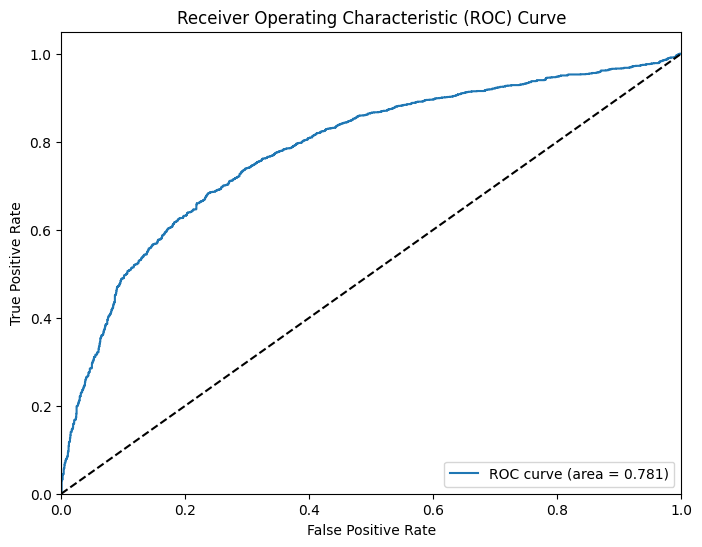

Model saved as 'melanoma_logistic_regression.pkl'


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import glob
from tqdm import tqdm

train_path = '/content/melanoma/DermMel/train_sep'
validate_path = '/content/melanoma/DermMel/valid'

def load_and_preprocess_images(directory, target_size=(128, 128)):
    images = []
    labels = []

    # Define class folders
    melanoma_dir = os.path.join(directory, 'Melanoma')
    notmelanoma_dir = os.path.join(directory, 'NotMelanoma')

    # Process melanoma images (class 1) - looking for both jpg and jpeg
    print(f"Looking for melanoma images in: {melanoma_dir}")
    melanoma_files_jpg = glob.glob(os.path.join(melanoma_dir, '*.jpg'))
    melanoma_files_jpeg = glob.glob(os.path.join(melanoma_dir, '*.jpeg'))
    melanoma_files = melanoma_files_jpg + melanoma_files_jpeg
    print(f"Found {len(melanoma_files)} melanoma images ({len(melanoma_files_jpg)} jpg, {len(melanoma_files_jpeg)} jpeg)")

    for img_path in tqdm(melanoma_files):
        try:
            # Load and resize image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)

            # Convert to numpy array and flatten
            img_array = np.array(img).flatten()

            images.append(img_array)
            labels.append(1)  # Melanoma class
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Process benign images (class 0)
    print(f"Looking for non-melanoma images in: {notmelanoma_dir}")
    benign_files = glob.glob(os.path.join(notmelanoma_dir, '*.jpg'))
    print(f"Found {len(benign_files)} non-melanoma images")

    for img_path in tqdm(benign_files):
        try:
            # Load and resize image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)

            # Convert to numpy array and flatten
            img_array = np.array(img).flatten()

            images.append(img_array)
            labels.append(0)  # Benign class
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load and preprocess training data
print("Loading training data...")
X_train, y_train = load_and_preprocess_images(train_path)
print(f"Training data shape: {X_train.shape}")

# Load and preprocess validation data
print("\nLoading validation data...")
X_val, y_val = load_and_preprocess_images(validate_path)
print(f"Validation data shape: {X_val.shape}")

# Normalize the data
print("\nNormalizing data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train logistic regression model
print("Training logistic regression model...")
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred = model.predict(X_val_scaled)
y_pred_prob = model.predict_proba(X_val_scaled)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
auc = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
import joblib
joblib.dump(model, 'melanoma_logistic_regression.pkl')
print("Model saved as 'melanoma_logistic_regression.pkl'")

# Baseline CNN Model

Checking for GPU...
Found 1 GPU(s)
GPU acceleration enabled
Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,897 (97.25 KB)

 Trainable params: 24,897 (97.25 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5852 - loss: 0.6753
Epoch 1: val_loss improved from inf to 0.62531, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 119s 668ms/step - accuracy: 0.5854 - loss: 0.6751 - val_accuracy: 0.6202 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 2/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6094 - loss: 0.6055

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.62531
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.6094 - loss: 0.6055 - val_accuracy: 0.5974 - val_loss: 0.6382 - learning_rate: 0.0010
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6497 - loss: 0.6202
Epoch 3: val_loss improved from 0.62531 to 0.58990, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 782ms/step - accuracy: 0.6497 - loss: 0.6202 - val_accuracy: 0.6517 - val_loss: 0.5899 - learning_rate: 0.0010
Epoch 4/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6094 - loss: 0.5707
Epoch 4: val_loss did not improve from 0.58990
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6094 - loss: 0.5707 - val_accuracy: 0.6284 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6839 - loss: 0.5787
Epoch 5: val_loss improved from 0.58990 to 0.53711, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 857ms/step - accuracy: 0.6841 - loss: 0.5785 - val_accuracy: 0.7611 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 6/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7188 - loss: 0.5407
Epoch 6: val_loss improved from 0.53711 to 0.52498, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7188 - loss: 0.5407 - val_accuracy: 0.7688 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7587 - loss: 0.5079
Epoch 7: val_loss improved from 0.52498 to 0.51738, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 508ms/step - accuracy: 0.7587 - loss: 0.5079 - val_accuracy: 0.7688 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 8/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7500 - loss: 0.5205
Epoch 8: val_loss improved from 0.51738 to 0.49696, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7500 - loss: 0.5205 - val_accuracy: 0.7918 - val_loss: 0.4970 - learning_rate: 0.0010
Epoch 9/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7772 - loss: 0.4896
Epoch 9: val_loss did not improve from 0.49696
166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 512ms/step - accuracy: 0.7772 - loss: 0.4896 - val_accuracy: 0.7565 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 10/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8438 - loss: 0.3983
Epoch 10: val_loss improved from 0.49696 to 0.48407, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.8438 - loss: 0.3983 - val_accuracy: 0.7759 - val_loss: 0.4841 - learning_rate: 0.0010
Epoch 11/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7862 - loss: 0.4731
Epoch 11: val_loss improved from 0.48407 to 0.46110, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 855ms/step - accuracy: 0.7861 - loss: 0.4732 - val_accuracy: 0.7886 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 12/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7812 - loss: 0.4591
Epoch 12: val_loss did not improve from 0.46110
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7812 - loss: 0.4591 - val_accuracy: 0.7815 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 13/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7857 - loss: 0.4682
Epoch 13: val_loss improved from 0.46110 to 0.44454, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 86s 520ms/step - accuracy: 0.7857 - loss: 0.4682 - val_accuracy: 0.8071 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 14/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8281 - loss: 0.4370
Epoch 14: val_loss did not improve from 0.44454
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.8281 - loss: 0.4370 - val_accuracy: 0.8009 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 15/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7862 - loss: 0.4586
Epoch 15: val_loss improved from 0.44454 to 0.44294, saving model to melanoma_simple_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 514ms/step - accuracy: 0.7863 - loss: 0.4586 - val_accuracy: 0.8125 - val_loss: 0.4429 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.


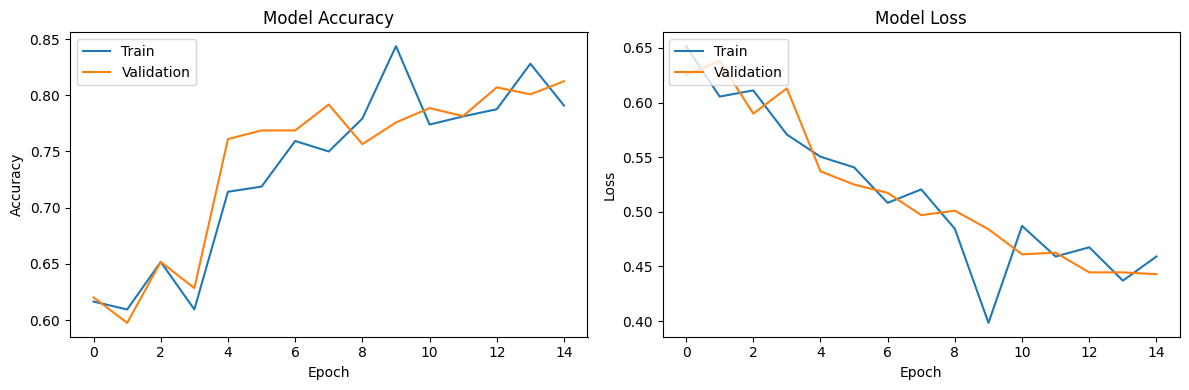

Evaluating model on validation data...
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step


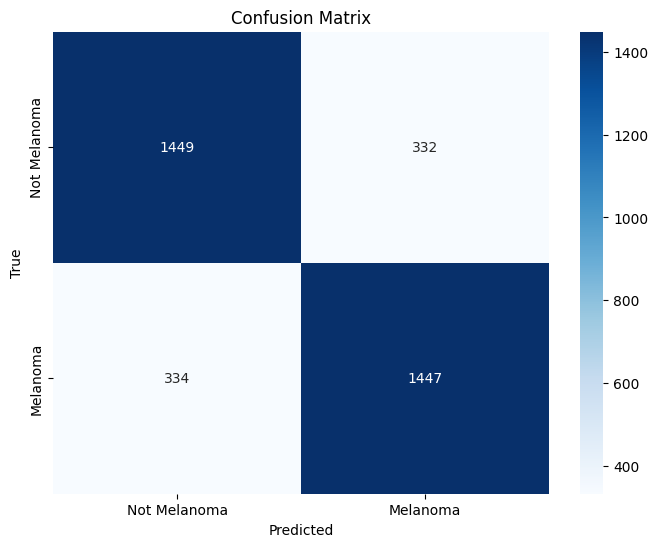


Classification Report:
              precision    recall  f1-score   support

Not Melanoma       0.81      0.81      0.81      1781
    Melanoma       0.81      0.81      0.81      1781

    accuracy                           0.81      3562
   macro avg       0.81      0.81      0.81      3562
weighted avg       0.81      0.81      0.81      3562



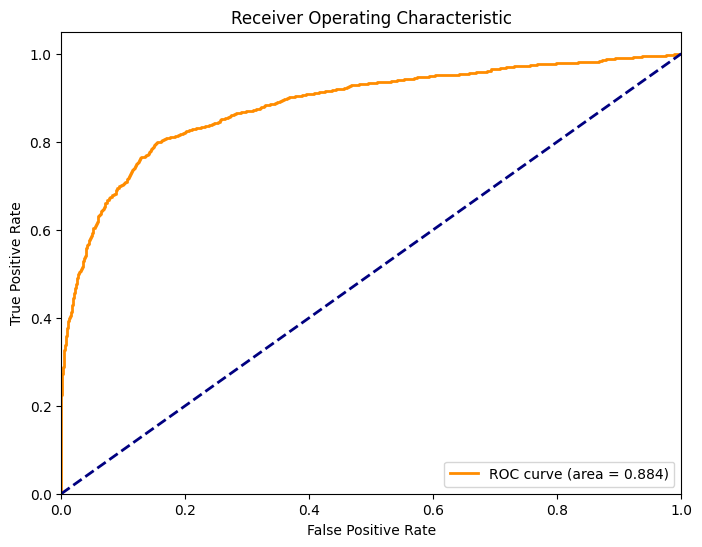

Model saved as 'melanoma_simple_cnn_model.h5'


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import tensorflow as tf

# Check for GPU availability and set it as device
print("Checking for GPU...")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU acceleration enabled")
else:
    print("No GPU found, using CPU")

# Define paths
train_path = '/content/melanoma/DermMel/train_sep'
valid_path = '/content/melanoma/DermMel/valid'

# Parameters - reduce image size for faster processing
IMG_SIZE = 128  # Reduced from 224
BATCH_SIZE = 64  # Increased batch size
EPOCHS = 15     # Reduced epochs

# Data augmentation for training set (simplified)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

# Only rescaling for validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create a baseline CNN model
model = Sequential([
    # Proper input layer to avoid warning
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 1st convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 3rd convolutional block
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Global pooling instead of multiple dense layers
    GlobalAveragePooling2D(),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Increased learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Set up callbacks
callbacks = [
    EarlyStopping(patience=3, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('melanoma_simple_cnn_model.h5', save_best_only=True, verbose=1)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model - removed workers and multiprocessing parameters
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on validation data
print("Evaluating model on validation data...")
validation_generator.reset()
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Melanoma', 'Melanoma'],
            yticklabels=['Not Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Not Melanoma', 'Melanoma']))

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save('melanoma_simple_cnn_model.h5')
print("Model saved as 'melanoma_simple_cnn_model.h5'")

**Baseline CNN Model with Optimized Thresholds**

Checking for GPU...
Found 1 GPU(s)
GPU acceleration enabled
Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,897 (97.25 KB)

 Trainable params: 24,897 (97.25 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.5861 - loss: 0.6622
Epoch 1: val_loss improved from inf to 0.62296, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 92s 526ms/step - accuracy: 0.5862 - loss: 0.6621 - val_accuracy: 0.6278 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 2/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7031 - loss: 0.5771

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.62296 to 0.61829, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.7031 - loss: 0.5771 - val_accuracy: 0.6392 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6498 - loss: 0.6160
Epoch 3: val_loss improved from 0.61829 to 0.60535, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 513ms/step - accuracy: 0.6498 - loss: 0.6160 - val_accuracy: 0.6619 - val_loss: 0.6054 - learning_rate: 0.0010
Epoch 4/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6875 - loss: 0.6173
Epoch 4: val_loss did not improve from 0.60535
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.6875 - loss: 0.6173 - val_accuracy: 0.6619 - val_loss: 0.6095 - learning_rate: 0.0010
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6637 - loss: 0.5968
Epoch 5: val_loss improved from 0.60535 to 0.54893, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 858ms/step - accuracy: 0.6637 - loss: 0.5967 - val_accuracy: 0.6963 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 6/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7500 - loss: 0.5593
Epoch 6: val_loss improved from 0.54893 to 0.54828, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.7500 - loss: 0.5593 - val_accuracy: 0.7009 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7099 - loss: 0.5468
Epoch 7: val_loss improved from 0.54828 to 0.49838, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 511ms/step - accuracy: 0.7101 - loss: 0.5467 - val_accuracy: 0.7659 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 8/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7500 - loss: 0.4834
Epoch 8: val_loss did not improve from 0.49838
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.7500 - loss: 0.4834 - val_accuracy: 0.7597 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 9/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7708 - loss: 0.4937
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 9: val_loss did not improve from 0.49838
166/166 ━━━━━━━━━━━━━━━━━━━━ 122s 513ms/step - accuracy: 0.7707 - loss: 0.4938 - val_accuracy: 0.7321 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 10/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7500 - loss: 0.5476
Epoch 10: val_loss did not improve from 0.49838
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.7500 - loss: 0.5476 - val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 510ms/step - accuracy: 0.7746 - loss: 0.4906 - val_accuracy: 0.7821 - val_loss: 0.4686 - learning_rate: 2.0000e-04
Epoch 12/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8906 - loss: 0.3497
Epoch 12: val_loss improved from 0.46865 to 0.46822, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8906 - loss: 0.3497 - val_accuracy: 0.7821 - val_loss: 0.4682 - learning_rate: 2.0000e-04
Epoch 13/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7949 - loss: 0.4593
Epoch 13: val_loss did not improve from 0.46822
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 634ms/step - accuracy: 0.7949 - loss: 0.4593 - val_accuracy: 0.7739 - val_loss: 0.4778 - learning_rate: 2.0000e-04
Epoch 14/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7500 - loss: 0.5198
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 14: val_loss did not improve from 0.46822
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7500 - loss: 0.5198 - val_accuracy: 0.7781 - val_loss: 0.4710 - learning_rate: 2.0000e-04
Epoch 15/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7812 - loss: 0.4695
Epoch 15: val_loss improved from 0.46822 to 0.46053, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 759ms/step - accuracy: 0.7812 - loss: 0.4694 - val_accuracy: 0.7909 - val_loss: 0.4605 - learning_rate: 4.0000e-05


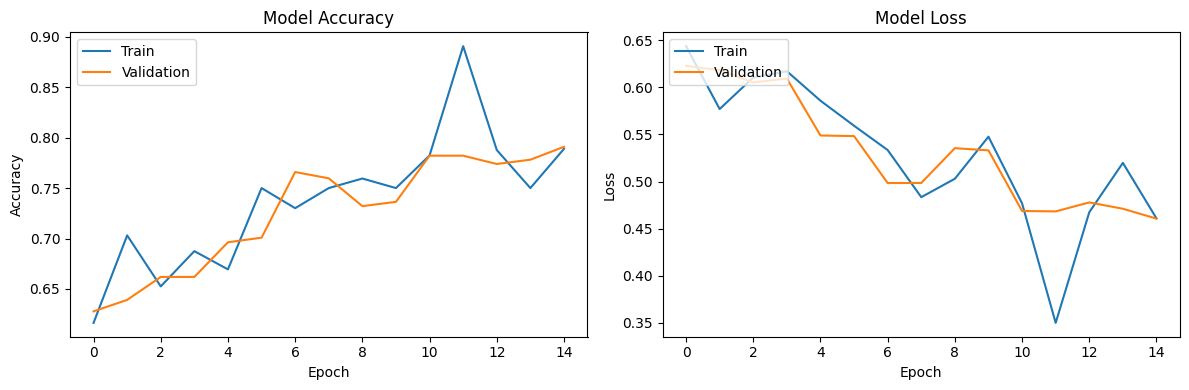

Evaluating model on validation data...
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step
Best threshold based on F1 score: 0.4418


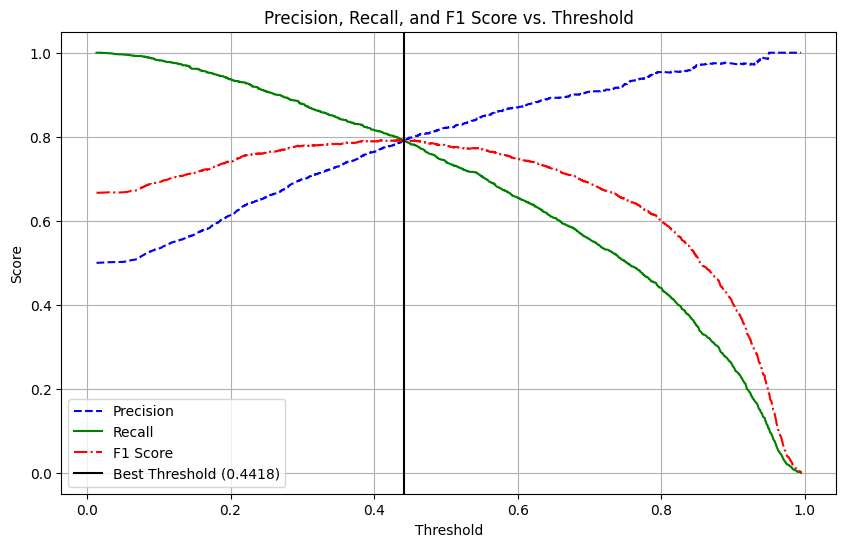


Classification Report with optimized threshold:
              precision    recall  f1-score   support

Not Melanoma       0.79      0.79      0.79      1781
    Melanoma       0.79      0.79      0.79      1781

    accuracy                           0.79      3562
   macro avg       0.79      0.79      0.79      3562
weighted avg       0.79      0.79      0.79      3562



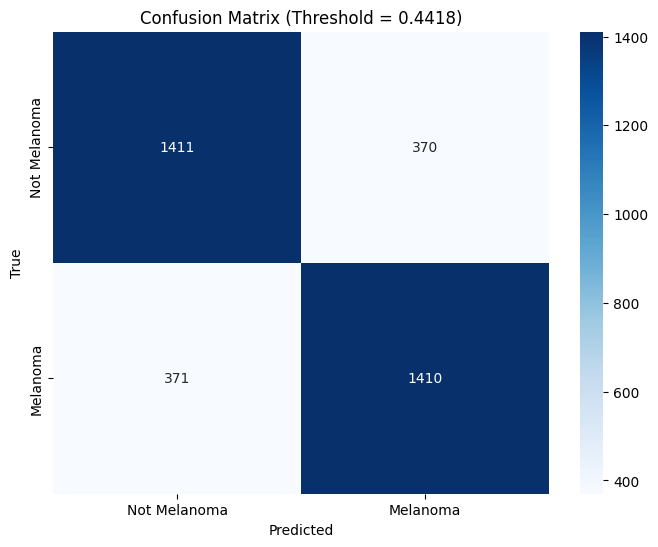

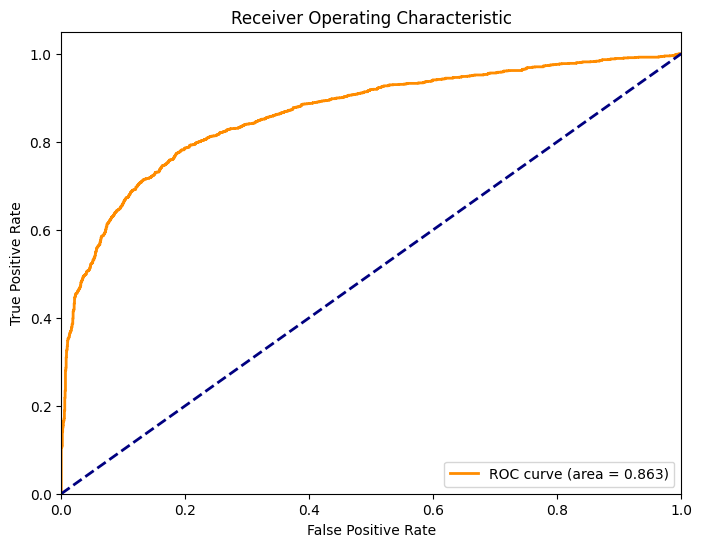

Model saved as 'melanoma_cnn_model.h5'


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns
import tensorflow as tf

# Check for GPU availability and set it as device
print("Checking for GPU...")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Found {len(physical_devices)} GPU(s)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU acceleration enabled")
else:
    print("No GPU found, using CPU")

# Define paths
train_path = '/content/melanoma/DermMel/train_sep'
valid_path = '/content/melanoma/DermMel/valid'

# Parameters - reduce image size for faster processing
IMG_SIZE = 128  # Reduced from 224
BATCH_SIZE = 64  # Increased batch size
EPOCHS = 15     # Reduced epochs

# Data augmentation for training set (simplified)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

# Only rescaling for validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create a baseline CNN model
model = Sequential([
    # Proper input layer to avoid warning
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 1st convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 3rd convolutional block
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Global pooling instead of multiple dense layers
    GlobalAveragePooling2D(),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Increased learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Set up callbacks - removed EarlyStopping
callbacks = [
    ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('melanoma_cnn_model.h5', save_best_only=True, verbose=1)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model - removed workers and multiprocessing parameters
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on validation data
print("Evaluating model on validation data...")
validation_generator.reset()
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)

# Skip default threshold evaluation and go straight to optimization

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Calculate F1 scores for different thresholds
f1_scores = []
for i in range(len(precision)):
    if i < len(thresholds):  # Handle the last point separately
        f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        f1_scores.append((thresholds[i], f1))
    else:
        f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        f1_scores.append((0.0, f1))  # For the last point, threshold is effectively 0

# Find threshold with highest F1 score
f1_scores.sort(key=lambda x: x[1], reverse=True)
best_threshold = f1_scores[0][0]
print(f"Best threshold based on F1 score: {best_threshold:.4f}")

# Plot precision and recall for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')

# Plot F1 scores
f1_scores_for_plot = [x[1] for x in sorted(f1_scores[:-1], key=lambda x: x[0])]
plt.plot(sorted([x[0] for x in f1_scores[:-1]]), f1_scores_for_plot, 'r-.', label='F1 Score')

plt.axvline(x=best_threshold, color='k', linestyle='-', label=f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Only evaluate with the best threshold
y_pred_best = (y_pred_prob > best_threshold).astype(int).flatten()
print("\nClassification Report with optimized threshold:")
print(classification_report(y_true, y_pred_best, target_names=['Not Melanoma', 'Melanoma']))

# Confusion matrix with best threshold
cm_best = confusion_matrix(y_true, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Melanoma', 'Melanoma'],
            yticklabels=['Not Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.show()

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save('melanoma_cnn_model.h5')
print("Model saved as 'melanoma_cnn_model.h5'")

# Transfer Learning Model

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,321 (9.89 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7428 - loss: 0.5789
Epoch 1: val_loss improved from inf to 0.31162, saving model to melanoma_cnn_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 109s 577ms/step - accuracy: 0.7432 - loss: 0.5781 - val_accuracy: 0.8986 - val_loss: 0.3116 - learning_rate: 1.0000e-04
Epoch 2/20
  1/166 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8438 - loss: 0.4948

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.31162
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8438 - loss: 0.4948 - val_accuracy: 0.8991 - val_loss: 0.3119 - learning_rate: 1.0000e-04
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8818 - loss: 0.3299
Epoch 3: val_loss did not improve from 0.31162
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 694ms/step - accuracy: 0.8817 - loss: 0.3299 - val_accuracy: 0.8736 - val_loss: 0.4228 - learning_rate: 1.0000e-04
Epoch 4/20
  1/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8906 - loss: 0.4092
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: val_loss did not improve from 0.31162
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8906 - loss: 0.4092 - val_accuracy: 0.8741 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8764 - loss: 0.3338
Epoch 5: val_loss did not improve from 0.31162
166/166 ━━━━━━━━━━━━━━━━━━━━

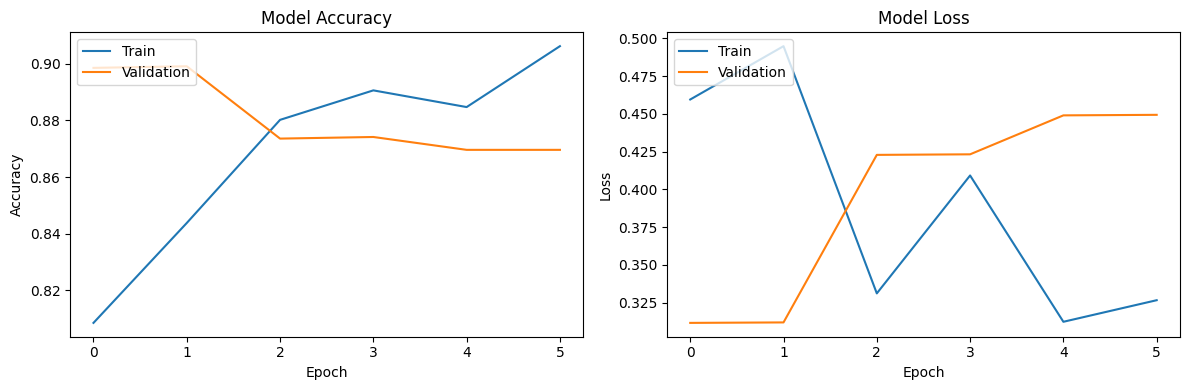

Evaluating model on validation data...
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step


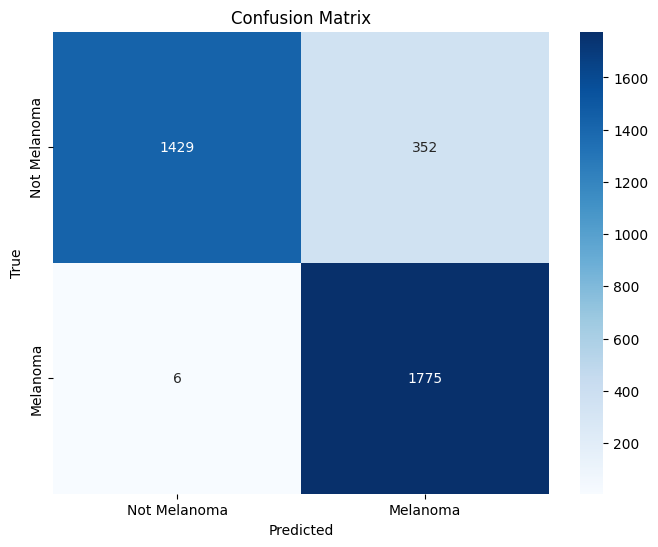


Classification Report:
              precision    recall  f1-score   support

Not Melanoma       1.00      0.80      0.89      1781
    Melanoma       0.83      1.00      0.91      1781

    accuracy                           0.90      3562
   macro avg       0.92      0.90      0.90      3562
weighted avg       0.92      0.90      0.90      3562



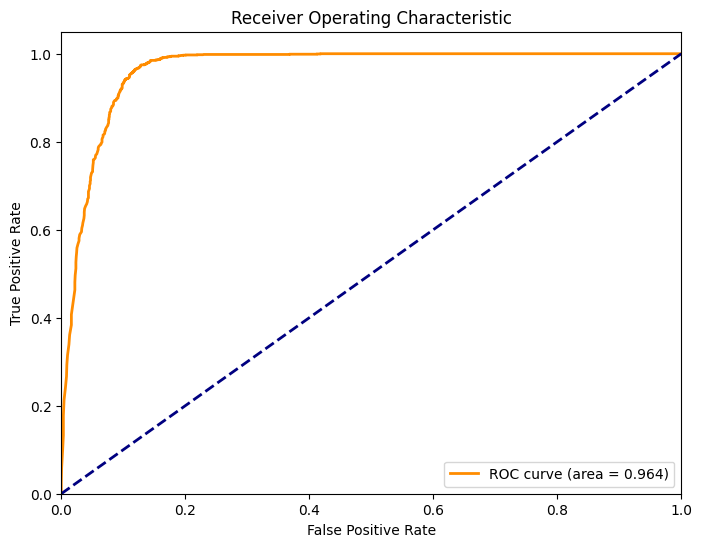

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define paths
train_path = '/content/melanoma/DermMel/train_sep'
valid_path = '/content/melanoma/DermMel/valid'

# Parameters - reduced image size and increased batch size
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 20

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create optimized model using transfer learning
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Set up callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('melanoma_cnn_model.h5', save_best_only=True, verbose=1)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on validation data
print("Evaluating model on validation data...")
validation_generator.reset()
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator, steps=validation_steps+1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Melanoma', 'Melanoma'],
            yticklabels=['Not Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Not Melanoma', 'Melanoma']))

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Transfer Learning Model with Optimized**

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,321 (9.89 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7089 - loss: 0.6416
Epoch 1: val_loss improved from inf to 0.37942, saving model to melanoma_mobilenet_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 104s 560ms/step - accuracy: 0.7094 - loss: 0.6407 - val_accuracy: 0.8722 - val_loss: 0.3794 - learning_rate: 1.0000e-04
Epoch 2/20
  1/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8281 - loss: 0.3950

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.37942 to 0.37630, saving model to melanoma_mobilenet_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.8281 - loss: 0.3950 - val_accuracy: 0.8733 - val_loss: 0.3763 - learning_rate: 1.0000e-04
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8662 - loss: 0.3484
Epoch 3: val_loss did not improve from 0.37630
166/166 ━━━━━━━━━━━━━━━━━━━━ 118s 515ms/step - accuracy: 0.8662 - loss: 0.3484 - val_accuracy: 0.8656 - val_loss: 0.4562 - learning_rate: 1.0000e-04
Epoch 4/20
  1/166 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8438 - loss: 0.4184
Epoch 4: val_loss did not improve from 0.37630
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.8438 - loss: 0.4184 - val_accuracy: 0.8665 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8857 - loss: 0.3158
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 5: val_loss did not improve from 0.37630
166/166 ━━━━━━━━━━━━━━━━━━━━ 142s 589ms/step - accuracy: 0.8857 - loss: 0.31

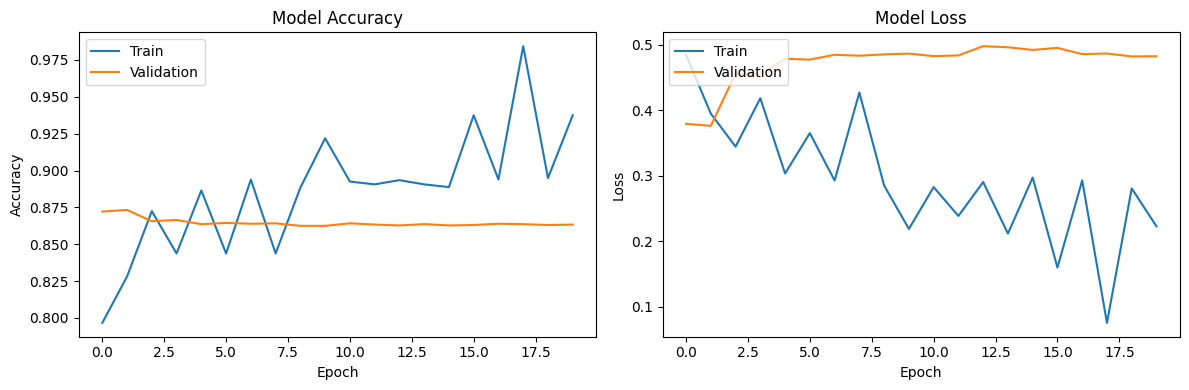

Evaluating model on validation data...
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step


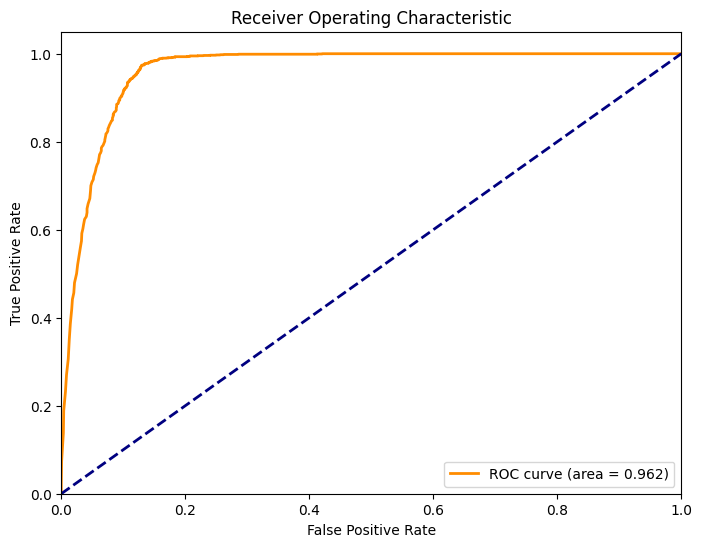

Best threshold based on F1 score: 0.8027


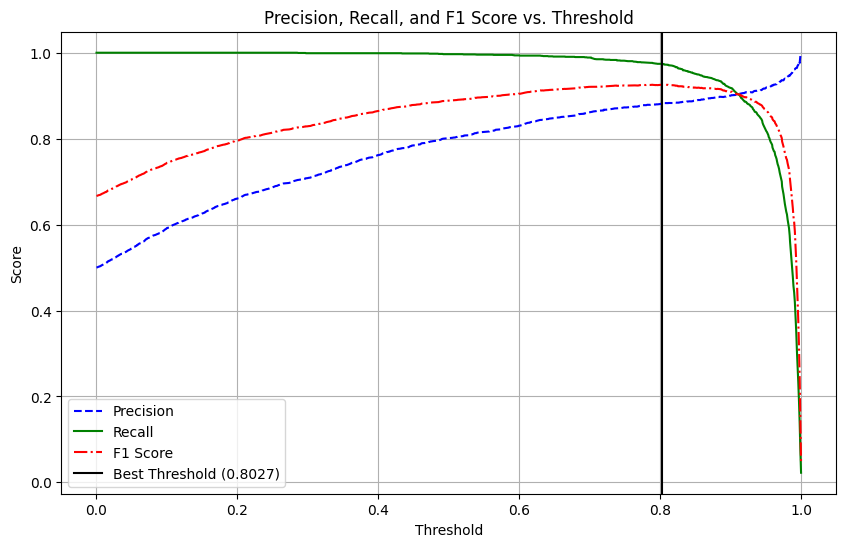


Classification Report with optimized threshold:
              precision    recall  f1-score   support

Not Melanoma       0.97      0.87      0.92      1781
    Melanoma       0.88      0.97      0.93      1781

    accuracy                           0.92      3562
   macro avg       0.93      0.92      0.92      3562
weighted avg       0.93      0.92      0.92      3562



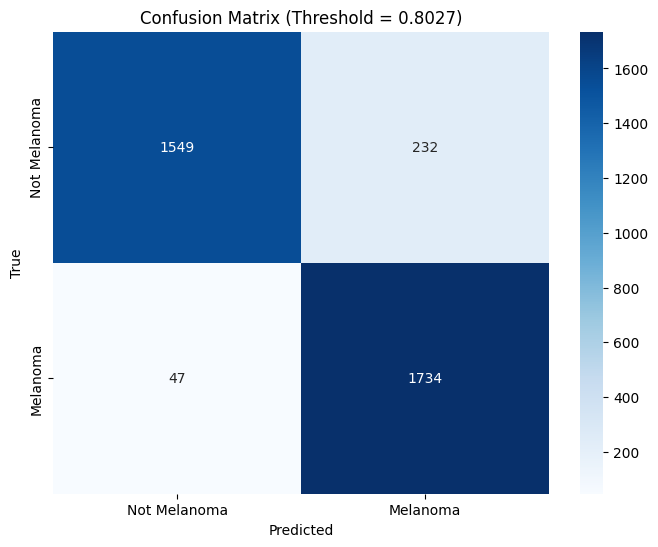

Model saved as 'melanoma_mobilenet_model.h5'


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define paths
train_path = '/content/melanoma/DermMel/train_sep'
valid_path = '/content/melanoma/DermMel/valid'

# Parameters - reduced image size and increased batch size
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 20

# Data augmentation for training set
train_datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   vertical_flip=True,
   fill_mode='nearest'
)

# Only rescaling for validation set
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
   train_path,
   target_size=(IMG_SIZE, IMG_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='binary',
   shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
   valid_path,
   target_size=(IMG_SIZE, IMG_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='binary',
   shuffle=False
)

# Create optimized model using transfer learning
base_model = MobileNetV2(
   input_shape=(IMG_SIZE, IMG_SIZE, 3),
   include_top=False,
   weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

model = Sequential([
   base_model,
   GlobalAveragePooling2D(),
   BatchNormalization(),
   Dense(256, activation='relu'),
   BatchNormalization(),
   Dropout(0.5),
   Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
   optimizer=Adam(learning_rate=0.0001),
   loss='binary_crossentropy',
   metrics=['accuracy']
)

# Print model summary
model.summary()

# Set up callbacks - removed EarlyStopping to run all epochs
callbacks = [
   ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6, verbose=1),
   ModelCheckpoint('melanoma_mobilenet_model.h5', save_best_only=True, verbose=1)
]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
   train_generator,
   steps_per_epoch=steps_per_epoch,
   epochs=EPOCHS,
   validation_data=validation_generator,
   validation_steps=validation_steps,
   callbacks=callbacks
)

# After training is complete, load the best weights
model.load_weights('melanoma_mobilenet_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on validation data
print("Evaluating model on validation data...")
validation_generator.reset()
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator, steps=validation_steps+1)

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Calculate F1 scores for different thresholds
f1_scores = []
for i in range(len(precision)):
   if i < len(thresholds):  # Handle the last point separately
       f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
       f1_scores.append((thresholds[i], f1))
   else:
       f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
       f1_scores.append((0.0, f1))  # For the last point, threshold is effectively 0

# Find threshold with highest F1 score
f1_scores.sort(key=lambda x: x[1], reverse=True)
best_threshold = f1_scores[0][0]
print(f"Best threshold based on F1 score: {best_threshold:.4f}")

# Plot precision and recall for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')

# Plot F1 scores
f1_scores_for_plot = [x[1] for x in sorted(f1_scores[:-1], key=lambda x: x[0])]
plt.plot(sorted([x[0] for x in f1_scores[:-1]]), f1_scores_for_plot, 'r-.', label='F1 Score')

plt.axvline(x=best_threshold, color='k', linestyle='-', label=f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Evaluate model with best threshold only
y_pred_best = (y_pred_prob > best_threshold).astype(int).flatten()
print("\nClassification Report with optimized threshold:")
print(classification_report(y_true, y_pred_best, target_names=['Not Melanoma', 'Melanoma']))

# Confusion matrix with best threshold
cm_best = confusion_matrix(y_true, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Not Melanoma', 'Melanoma'],
           yticklabels=['Not Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.show()

# Save the model
model.save('melanoma_mobilenet_model.h5')
print("Model saved as 'melanoma_mobilenet_model.h5'")